# Определение стоимости автомобилей

# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

# Импортируем нужные lib

In [ ]:
CatBoostRegressor, RandomForestRegressor, DecisionTreeRegressor, lightgbm

In [260]:
#для работы с данными
import pandas as pd
import numpy as np
from tqdm import tqdm 
import time
import matplotlib.pyplot as plt
import seaborn as sns 
import json

#для создания моделей 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder 


pd.set_option('display.max_columns', None)

# Функции

In [ ]:
def render_metric(metric_name):
    lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()
    
def render_plot_importance(importance_type, max_features=10, ignore_zero=True, precision=3):
    lgb.plot_importance(
        gbm,
        importance_type=importance_type,
        max_num_features=max_features,
        ignore_zero=ignore_zero,
        figsize=(12, 8),
        precision=precision,
    )
    plt.show()

# Загрузка данных 

In [89]:
df = pd.read_csv('autos.csv')

In [90]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


___Признаки___

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

___Целевой признак___

- Price — цена (евро)

# Обработка данных

In [91]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [92]:
(df.isna().sum()/len(df))*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [93]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удалим аномалии в которых цена за машину равна нулю 

In [94]:
df = df.query('Price != 0').reset_index(drop = True)

И где год больше текущего

In [95]:
df = df.query('RegistrationYear<2025')

Удалим бесполезный признак

In [96]:
df = df.drop(columns = 'NumberOfPictures')

In [97]:
(df.isna().sum()/len(df))*100

DateCrawled           0.000000
Price                 0.000000
VehicleType           9.799977
RegistrationYear      0.000000
Gearbox               5.033027
Power                 0.000000
Model                 5.092413
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              8.558387
Brand                 0.000000
Repaired             19.152807
DateCreated           0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [98]:
df.VehicleType.value_counts(normalize = True)*100

VehicleType
sedan          28.854564
small          25.179524
wagon          20.558856
bus             9.148063
convertible     6.411229
coupe           5.046362
suv             3.805427
other           0.995975
Name: proportion, dtype: float64

In [99]:
df.VehicleType = df.VehicleType.fillna('unknown')

In [100]:
df.Gearbox = df.Gearbox.fillna('unknown')

In [101]:
df.Model = df.Model.fillna('unknown')

In [102]:
df.FuelType = df.FuelType.fillna('unknown')

In [103]:
df.Repaired = df.Repaired.fillna('not specified')

In [104]:
(df.isna().sum()/len(df))*100

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

Первичным решением было не удалять данные которых нет, так как в пропущенных значениях одного признака присутствуют заполненные значения других признако. Так же мы должны учитывать, что некоторые пропуски являлись специально сделанными, потому что пользователь не желал упоминать эту информацию в анкете

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343511 entries, 0 to 343596
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        343511 non-null  object
 1   Price              343511 non-null  int64 
 2   VehicleType        343511 non-null  object
 3   RegistrationYear   343511 non-null  int64 
 4   Gearbox            343511 non-null  object
 5   Power              343511 non-null  int64 
 6   Model              343511 non-null  object
 7   Kilometer          343511 non-null  int64 
 8   RegistrationMonth  343511 non-null  int64 
 9   FuelType           343511 non-null  object
 10  Brand              343511 non-null  object
 11  Repaired           343511 non-null  object
 12  DateCreated        343511 non-null  object
 13  PostalCode         343511 non-null  int64 
 14  LastSeen           343511 non-null  object
dtypes: int64(6), object(9)
memory usage: 41.9+ MB


# Преобразование временных признаков

In [123]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

In [124]:
df['DateCrawled_year'] = df['DateCrawled'].dt.year
df['DateCreated_year'] = df['DateCreated'].dt.year
df['LastSeen_year'] = df['LastSeen'].dt.year

In [125]:
df['DateCrawled_mnth'] = df['DateCrawled'].dt.month
df['DateCreated_mnth'] = df['DateCreated'].dt.month
df['LastSeen_mnth'] = df['LastSeen'].dt.month

In [126]:
df['DateCrawled_day'] = df['DateCrawled'].dt.day
df['DateCreated_day'] = df['DateCreated'].dt.day
df['LastSeen_day'] = df['LastSeen'].dt.day

In [127]:
df['DateCrawled_day_of_week'] = df['DateCrawled'].dt.dayofweek
df['DateCreated_day_of_week'] = df['DateCreated'].dt.dayofweek
df['LastSeen_day_of_week'] = df['LastSeen'].dt.dayofweek

In [128]:
df_new = df.drop(columns = ['DateCrawled','DateCreated','LastSeen'])

# Проверим зависимость признаков от целевой переменной

## Матрица корреляций

In [141]:
df_new = df_new.reset_index(drop = True)

In [149]:
cm = df_new[['Price','RegistrationYear','Power','Kilometer','RegistrationMonth','PostalCode','DateCrawled_year','DateCreated_year','LastSeen_year'\
            ,'DateCrawled_mnth','DateCreated_mnth','LastSeen_mnth','DateCrawled_day_of_week','DateCreated_day_of_week','LastSeen_day_of_week'
            ]].corr()

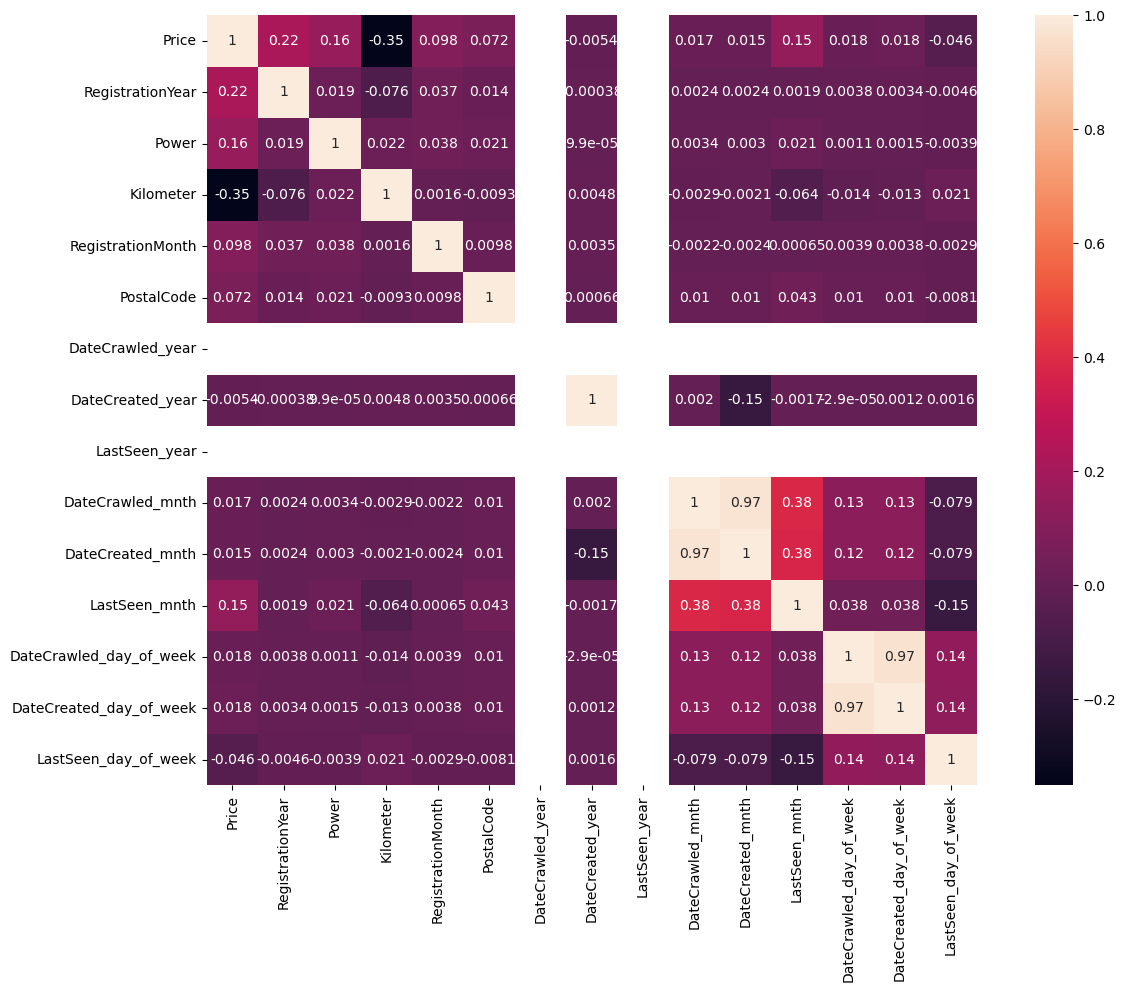

In [154]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(cm, annot = True, square = True)
plt.show()

__Вывод:__ PostalCode, DateCrawled_year, LastSeen_year можно не учитывать в признаках 

In [157]:
df_new.drop(columns = ['PostalCode','DateCrawled_year','LastSeen_year'], inplace = True)

In [160]:
val = df_new[['Price','RegistrationYear','Power','Kilometer','RegistrationMonth','DateCreated_year',\
            'DateCrawled_mnth','DateCreated_mnth','LastSeen_mnth','DateCrawled_day_of_week','DateCreated_day_of_week','LastSeen_day_of_week'
            ]]

In [169]:
val

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated_year,DateCrawled_mnth,DateCreated_mnth,LastSeen_mnth,DateCrawled_day_of_week,DateCreated_day_of_week,LastSeen_day_of_week
0,480,1993,0,150000,0,2016,3,3,4,3,3,3
1,18300,2011,190,125000,5,2016,3,3,4,3,3,3
2,9800,2004,163,125000,8,2016,3,3,4,0,0,1
3,1500,2001,75,150000,6,2016,3,3,3,3,3,3
4,3600,2008,69,90000,7,2016,3,3,4,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
343506,1150,2000,0,150000,3,2016,3,3,3,6,6,1
343507,2200,2005,0,20000,1,2016,3,3,4,0,0,2
343508,1199,2000,101,125000,3,2016,3,3,3,5,5,4
343509,9200,1996,102,150000,3,2016,3,3,4,5,5,3


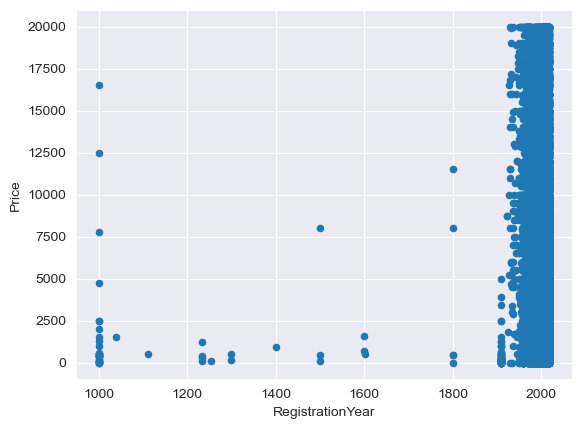

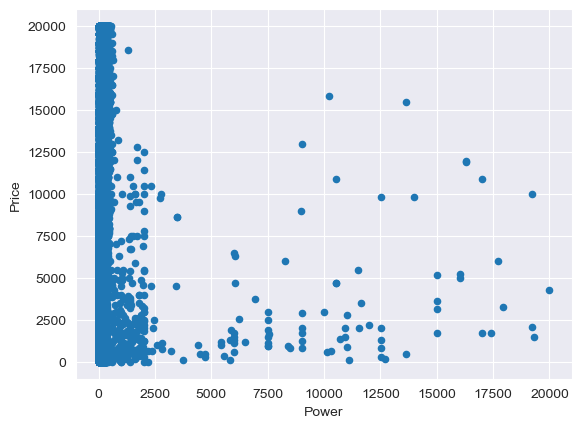

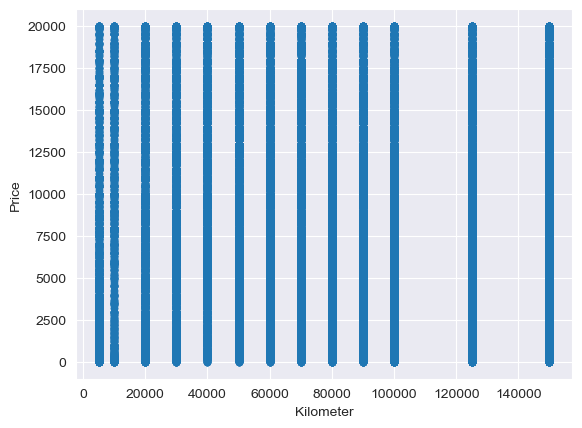

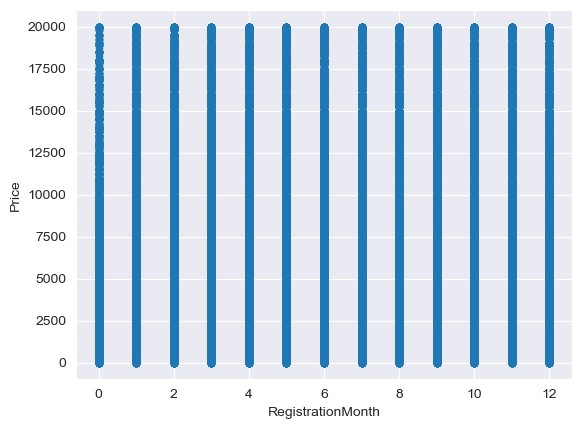

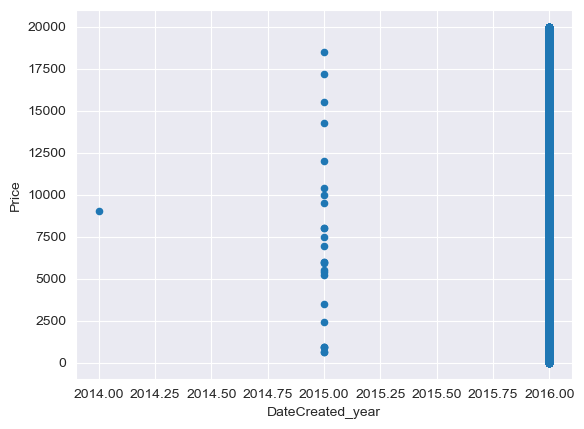

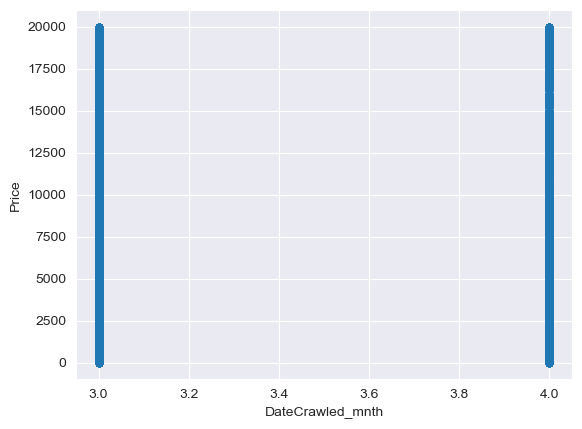

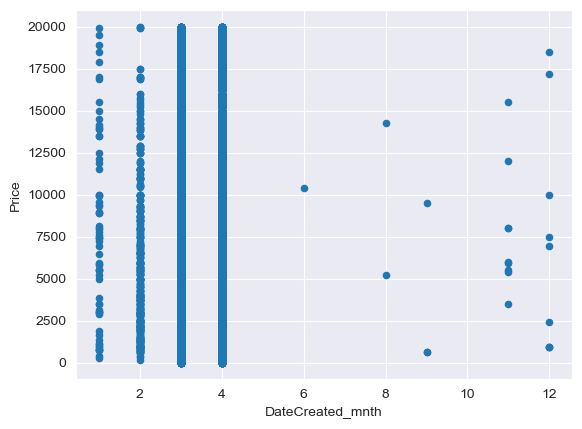

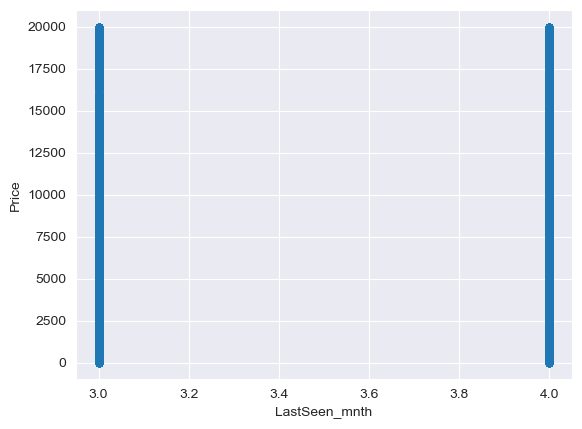

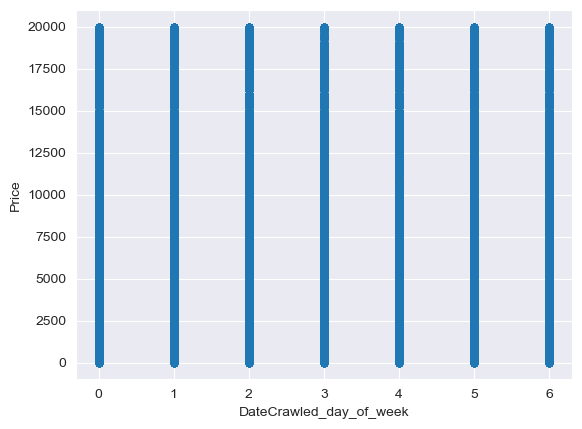

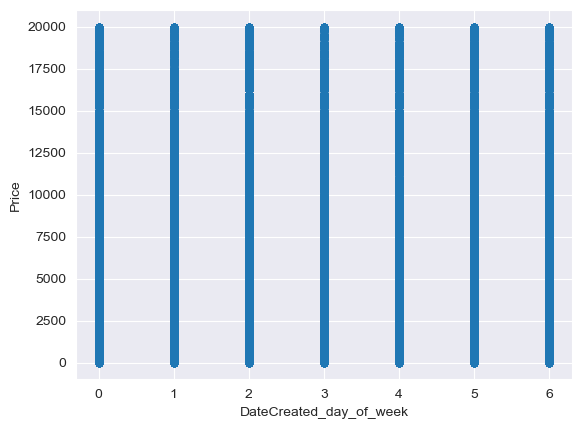

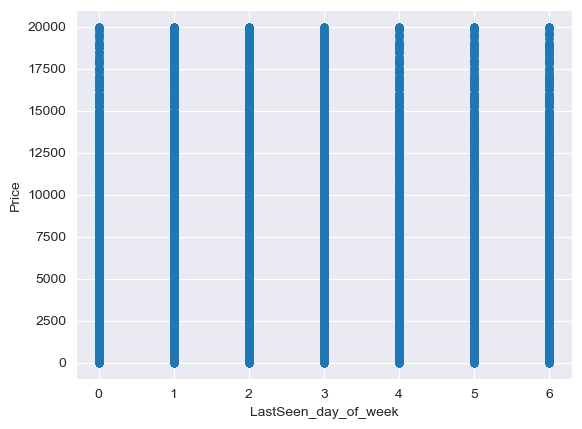

In [168]:
for col in [i for i in val.columns if i!='Price']:
    val.plot(x = col, y = 'Price', kind = 'scatter')

___Вывод:___ линейная зависимость практически везде отсутсвуют, так что будем обходиться деревьями, которые умеют находить связи в нелинейных зависимостях 

# Разделение выборок

In [179]:
categorial = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

In [182]:
X = df_new.drop(columns = 'Price')
y = df_new['Price']

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [218]:
X_train.reset_index(drop = True, inplace= True)

In [219]:
X_test.reset_index(drop = True, inplace= True)

In [214]:
y_train.reset_index(drop = True, inplace = True)

In [215]:
y_test.reset_index(drop = True, inplace = True)

## Преобразование категориальных переменных 

Преобразовываем только категориальные, так как в моделях, которые мы будем использовать нет чуствительности к количественным выбросам

In [197]:
encoder = OrdinalEncoder() 

In [200]:
encoder.fit(X_train[categorial]) 

OrdinalEncoder()

In [203]:
data_ordinal_train = pd.DataFrame(encoder.transform(X_train[categorial]),columns=X_train[categorial].columns) 

In [204]:
data_ordinal_test = pd.DataFrame(encoder.transform(X_test[categorial]),columns=X_test[categorial].columns) 

In [222]:
X_train = pd.concat([X_train[[col for col in X_train.columns if col not in categorial]], data_ordinal_train],axis = 1 )

In [223]:
X_test = pd.concat([X_test[[col for col in X_test.columns if col not in categorial]], data_ordinal_test],axis = 1 )

Данные для обучения готовы

# lgb

## Создание датасетов

In [225]:
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    feature_name=[f"f{i + 1}" for i in range(X_train.shape[-1])]
)

In [226]:
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

## Сетка параметров

In [231]:
try:
    from ipywidgets import SelectMultiple, interact

    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

In [227]:
params = {"num_leaves": 5, "metric": ["l1", "l2"], "verbose": -1}

## Обучение модели 

In [247]:
evals_result = {}  # это пустой словарь, который будет заполняться метриками качества модели после каждой итерации обучения

start_time = time.time()

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100, #модель будет обучаться 100 итераций (создаст 100 деревьев)
    valid_sets=[lgb_train, lgb_test], #метрики будут считаться на обучающих данных и на тестовых
    callbacks=[lgb.log_evaluation(10), lgb.record_evaluation(evals_result)],#указывает вывести каждую 10 итерацию и записывать все в словарь evals_result
)

end_time = time.time()
training_time = end_time - start_time

print(f"Модель обучилась за {training_time:.2f} секунд")

[10]	training's l1: 2303.34	training's l2: 9.68249e+06	valid_1's l1: 2313.59	valid_1's l2: 9.77497e+06
[20]	training's l1: 1841.95	training's l2: 6.76576e+06	valid_1's l1: 1847.54	valid_1's l2: 6.79566e+06
[30]	training's l1: 1632.31	training's l2: 5.65385e+06	valid_1's l1: 1635.83	valid_1's l2: 5.66785e+06
[40]	training's l1: 1524.62	training's l2: 5.15354e+06	valid_1's l1: 1526.65	valid_1's l2: 5.16408e+06
[50]	training's l1: 1451.4	training's l2: 4.81721e+06	valid_1's l1: 1452.26	valid_1's l2: 4.82884e+06
[60]	training's l1: 1401.08	training's l2: 4.58034e+06	valid_1's l1: 1401.13	valid_1's l2: 4.59462e+06
[70]	training's l1: 1365.36	training's l2: 4.40749e+06	valid_1's l1: 1365.36	valid_1's l2: 4.42713e+06
[80]	training's l1: 1337.84	training's l2: 4.27359e+06	valid_1's l1: 1338.22	valid_1's l2: 4.2971e+06
[90]	training's l1: 1321.24	training's l2: 4.17626e+06	valid_1's l1: 1321.81	valid_1's l2: 4.20358e+06
[100]	training's l1: 1305.66	training's l2: 4.09233e+06	valid_1's l1: 1306.

По итогу в конце 100ого дерева мы получаем следующее качество

In [248]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=params["metric"])
else:
    render_metric(params["metric"][0])

interactive(children=(Dropdown(description='metric_name', options=('l1', 'l2'), value='l1'), Output()), _dom_c…

In [249]:
if INTERACTIVE:
    interact(
        render_plot_importance,
        importance_type=["split", "gain"],
        max_features=(1, X_train.shape[-1]),
        precision=(0, 10),
    )
else:
    render_plot_importance(importance_type="split")

interactive(children=(Dropdown(description='importance_type', options=('split', 'gain'), value='split'), IntSl…

In [250]:
importance = gbm.feature_importance(importance_type='split')
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print(importance_df.head(20))

                    feature  importance
0          RegistrationYear         111
1                     Power          83
18                    Brand          59
2                 Kilometer          36
14              VehicleType          34
16                    Model          19
19                 Repaired          18
7             LastSeen_mnth          11
17                 FuelType          11
15                  Gearbox          10
10             LastSeen_day           6
3         RegistrationMonth           2
8           DateCrawled_day           0
9           DateCreated_day           0
6          DateCreated_mnth           0
11  DateCrawled_day_of_week           0
12  DateCreated_day_of_week           0
13     LastSeen_day_of_week           0
5          DateCrawled_mnth           0
4          DateCreated_year           0


Самыми важными признаками оказались год регистрации, мощность и бренд

In [251]:
predictions = gbm.predict(X_test)

In [252]:
mean_squared_error(y_test,predictions)**0.5

2029.6830790536774

## Сохранение модели

In [255]:
gbm.save_model("model.txt")

model_json = gbm.dump_model()

with open("model.json", "w+") as f:
    json.dump(model_json, f, indent=4)

___Вывод:___ по задаче необходимо было достичь качества метрики RMSE в 2500 тысячи единиц, у нас это получилось с 1 раза. Модель обучалась меньше секунды !

# CatBoostRegressor

## Создание датасетов

In [256]:
train_pool = Pool(X_train,
                  y_train,)
test_pool = Pool(X_test,)

## Обучение модели

In [263]:
params = {
            'iterations':[100,200,500],
            'depth':[5,10],
            'learning_rate':[0.01,0.1],
}

In [264]:
model = CatBoostRegressor(random_state=42,
                          loss_function='RMSE')

In [265]:
clf = RandomizedSearchCV(estimator=model,param_distributions=params,random_state=42,cv=3)

In [267]:
search = clf.fit(X_train,y_train)


0:	learn: 4481.7423245	total: 19.9ms	remaining: 9.91s
1:	learn: 4450.5866310	total: 33.8ms	remaining: 8.43s
2:	learn: 4419.9797055	total: 48.8ms	remaining: 8.08s
3:	learn: 4389.7063728	total: 64.9ms	remaining: 8.04s
4:	learn: 4359.5092196	total: 80.8ms	remaining: 8s
5:	learn: 4329.7797653	total: 94.8ms	remaining: 7.8s
6:	learn: 4300.4038519	total: 109ms	remaining: 7.69s
7:	learn: 4271.4047733	total: 124ms	remaining: 7.61s
8:	learn: 4243.1523963	total: 138ms	remaining: 7.51s
9:	learn: 4214.6872148	total: 152ms	remaining: 7.46s
10:	learn: 4186.5697699	total: 166ms	remaining: 7.39s
11:	learn: 4159.3057742	total: 180ms	remaining: 7.34s
12:	learn: 4132.3724732	total: 195ms	remaining: 7.3s
13:	learn: 4105.7738516	total: 209ms	remaining: 7.25s
14:	learn: 4079.2418378	total: 223ms	remaining: 7.22s
15:	learn: 4053.3137003	total: 238ms	remaining: 7.21s
16:	learn: 4027.2519883	total: 252ms	remaining: 7.17s
17:	learn: 4002.0412341	total: 267ms	remaining: 7.15s
18:	learn: 3977.0243927	total: 281ms	

{'learning_rate': 0.1, 'iterations': 500, 'depth': 10}

In [268]:
search.best_params_

{'learning_rate': 0.1, 'iterations': 500, 'depth': 10}

In [269]:
model = CatBoostRegressor(iterations=500,
                          depth=10,
                          learning_rate=0.1,
                          loss_function='RMSE')

In [271]:
start_time = time.time()

model.fit(train_pool)
preds = model.predict(test_pool)

end_time = time.time()
training_time = end_time - start_time



0:	learn: 4198.0904083	total: 23.6ms	remaining: 11.8s
1:	learn: 3927.3055573	total: 43.5ms	remaining: 10.8s
2:	learn: 3688.8797397	total: 62.3ms	remaining: 10.3s
3:	learn: 3477.0743629	total: 80.8ms	remaining: 10s
4:	learn: 3286.7295922	total: 98.9ms	remaining: 9.79s
5:	learn: 3121.6511930	total: 117ms	remaining: 9.66s
6:	learn: 2973.8729062	total: 136ms	remaining: 9.57s
7:	learn: 2846.9466252	total: 154ms	remaining: 9.48s
8:	learn: 2738.4443135	total: 173ms	remaining: 9.45s
9:	learn: 2641.7455322	total: 196ms	remaining: 9.59s
10:	learn: 2559.4127824	total: 216ms	remaining: 9.6s
11:	learn: 2484.4670762	total: 237ms	remaining: 9.63s
12:	learn: 2421.7170532	total: 256ms	remaining: 9.61s
13:	learn: 2363.0898033	total: 276ms	remaining: 9.59s
14:	learn: 2308.8414853	total: 296ms	remaining: 9.55s
15:	learn: 2264.9884261	total: 315ms	remaining: 9.52s
16:	learn: 2227.7331975	total: 335ms	remaining: 9.5s
17:	learn: 2191.6993106	total: 354ms	remaining: 9.47s
18:	learn: 2161.7067594	total: 372ms	

In [272]:
print(f"Модель обучилась за {training_time:.2f} секунд")

Модель обучилась за 10.75 секунд


In [273]:
mean_squared_error(y_test,preds)**0.5

1606.7065502318337

In [280]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

In [281]:
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

In [283]:
importance_df.sort_values(by = 'importance', ascending = False)

,feature,importance
0,RegistrationYear,32.936129
1,Power,21.309490
18,Brand,11.172606
2,Kilometer,9.719096
14,VehicleType,7.407994
16,Model,4.402767
17,FuelType,3.263482
19,Repaired,3.174235
15,Gearbox,1.709565
7,LastSeen_mnth,1.182870


По топу признаков обе модели пришли к единому мнению

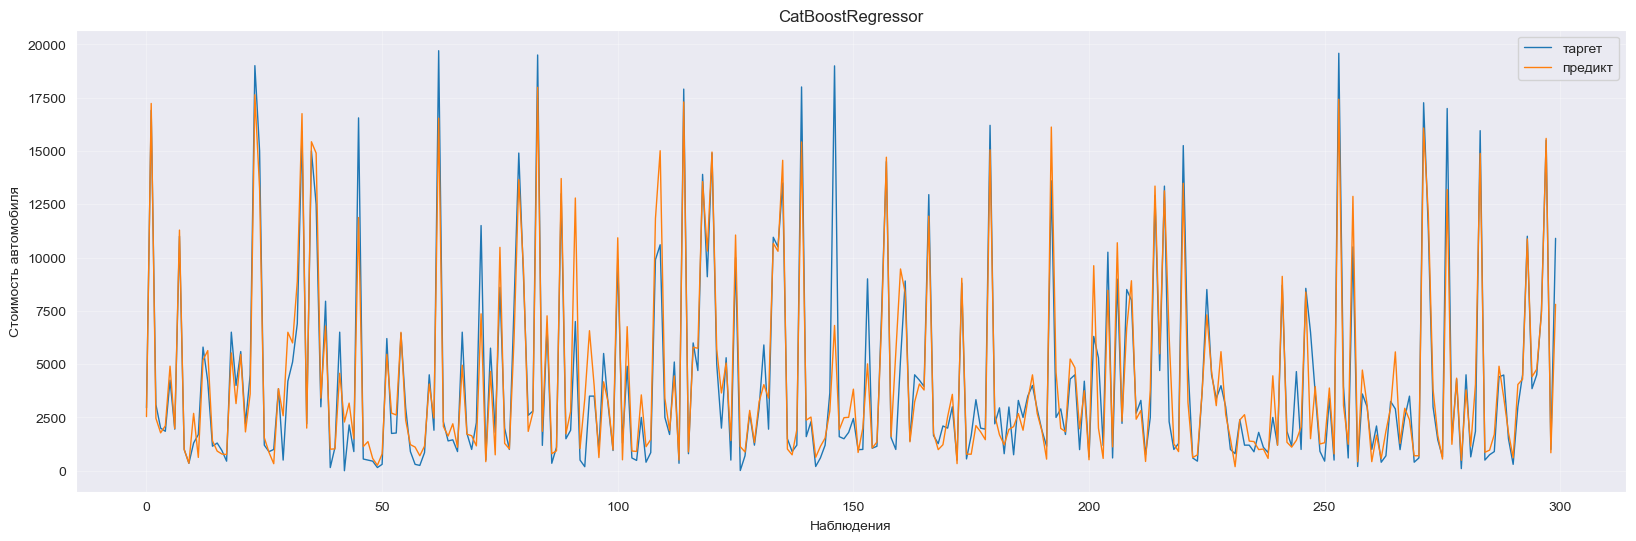

In [294]:
x = [i for i in range(len(y_test[:300]))]
y1 = y_test[:300]
y2 = preds[:300]

plt.figure(figsize=(20, 6))

plt.plot(x, y1, label='таргет', linewidth=1)
plt.plot(x, y2, label='предикт', linewidth=1)

plt.xlabel('Наблюдения')
plt.ylabel('Стоимость автомобиля')
plt.title('CatBoostRegressor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

__Вывод__: качество модели получилось лучше, чем у модели построенной на lgb, метрика ошибка в 1600 при среднем наблюдении в 4500 неплохое решение. Из минусов то, что модель обучается чуть больше чем lgb из за количества деревьев. 